In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy

import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch
from multiprocessing import Pool
import pickle

from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import col, svg, get_labels_8pt
import stg_energy.fig2_inference.viz as viz
from sbi.analysis import pairplot
from stg_energy.common import check_if_close_to_obs
import itertools
from sbi.utils import BoxUniform

# Figure 1

In [3]:
pd.options.display.max_columns=999

In [4]:
# from sbi.utils.user_input_checks_utils import PytorchReturnTypeWrapper

In [5]:
PANEL_A = '../svg/panel_a.svg'
PANEL_B = '../svg/panel_b.svg'
PANEL_C = '../svg/panel_c.svg'
PANEL_D = '../svg/panel_d.svg'
PANEL_E = '../svg/panel_e.svg'
PANEL_F = '../svg/panel_f.svg'
PANEL_G = '../svg/panel_g.svg'
PANEL_H = '../svg/panel_h.svg'
PANEL_I = '../svg/panel_i.svg'

### Select the simulations that were close

In [6]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster"
theta = pd.read_pickle(path + '/close_to_xo_circuit_parameters.pkl')
x = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
seeds = np.load(path + '/close_to_xo_seeds.npy')
theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Load network

In [7]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.base_constraint.lower_bound
upper_bound = prior.support.base_constraint.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T
# dimensions = 31
# lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T

# Panel B: experimental data

In [8]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']

# Panel D: posterior samples

In [9]:
esglut_mean = -70
kminusglut_mean = 40
eschol_mean = -80
kminuschol_mean = 100
vth_mean = -35.0
delta_mean = 5.0

esglut_diff = 20
kminusglut_diff = 15
eschol_diff = 20
kminuschol_diff = 20
vth_diff = 10.0
delta_diff = 1.0

diffs = [[esglut_diff]*5, [kminusglut_diff]*5, [eschol_diff]*2, [kminuschol_diff]*2, [vth_diff]*7, [delta_diff]*7]
diffs = list(itertools.chain(*diffs))

means = [[esglut_mean]*5, [kminusglut_mean]*5, [eschol_mean]*2, [kminuschol_mean]*2, [vth_mean]*7, [delta_mean]*7]
means = list(itertools.chain(*means))

diff = torch.tensor(diffs)
mean = torch.tensor(means)
prior_size = 2.0
prior_synapses = BoxUniform(mean-diff*prior_size, mean+diff*prior_size)

In [10]:
def my_simulator(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        energy_measure="current"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [11]:
def my_simulator_synaptic(theta_synaptic):
    
    Esglut=theta_synaptic[0:5].tolist()
    kminusglut=theta_synaptic[5:10].tolist()
    Eschol=theta_synaptic[10:12].tolist()
    kminuschol=theta_synaptic[12:14].tolist()
    Vth=theta_synaptic[14:21].tolist()
    Delta=theta_synaptic[21:28].tolist()
    seed=theta_synaptic[28].item()
    
    out_target = simulate(
        theta_conductance,
        seed=int(seed),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        Esglut=Esglut, 
        kminusglut=kminusglut, 
        Eschol=Eschol, 
        kminuschol=kminuschol, 
        Vth=Vth, 
        Delta=Delta
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [12]:
data_np = theta.to_numpy()
params_with_seeds = np.concatenate((data_np, seeds[:, None]), axis=1)

In [13]:
params_with_seeds.shape

(35939, 32)

In [14]:
with Pool(16) as pool:
    start_time = time.time()
    data1 = pool.map(my_simulator, params_with_seeds[:10])
    print("Simulation time", time.time() - start_time)

sims_out1 = pd.concat(data1, ignore_index=True)

Simulation time 1.3842217922210693


In [15]:
close = check_if_close_to_obs(sims_out1.to_numpy(), sloppiness_durations=1.0, sloppiness_phases=1.0)
print(close)

[ True  True  True  True  True  True  True  True  True  True]


In [24]:
time_vec = np.arange(0, 11000, 0.025)

In [30]:
num_sims = 100000

In [33]:
# for config_ind in range(10):
#     theta_conductance = theta.loc[config_ind]
#     print("============== ", config_ind)
    
#     for seed in range(50):
#         _ = torch.manual_seed(seed)
#         seeds = torch.randint(0, 1000000, (int(num_sims / 50),)).unsqueeze(1)
#         theta_synaptic = prior_synapses.sample((int(num_sims / 50),))
#         params_with_seeds = torch.cat([theta_synaptic, seeds], dim=1)

#         with Pool(16) as pool:
#             start_time = time.time()
#             data1 = pool.map(my_simulator_synaptic, params_with_seeds)
#             print("Simulation time", time.time() - start_time)

#         sims_out1 = pd.concat(data1, ignore_index=True)
#         sims_out1.to_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_{seed}.pkl")
#         with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_{seed}.pkl", "wb") as handle:
#             pickle.dump(theta_synaptic, handle)
#         with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_{seed}.pkl", "wb") as handle:
#             pickle.dump(seeds, handle)

In [34]:
# for config_ind in range(10):
#     all_sims = []
#     all_theta = []
#     all_seeds = []
#     for seed in range(50):
#         sims_out1 = pd.read_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_{seed}.pkl")
#         with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_{seed}.pkl", "rb") as handle:
#             theta_synaptic = pickle.load(handle)
#         with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_{seed}.pkl", "rb") as handle:
#             seeds = pickle.load(handle)
            
#         all_sims.append(sims_out1)
#         all_theta.append(theta_synaptic)
#         all_seeds.append(seeds)
#     all_sims = pd.concat(all_sims, ignore_index=True)
#     all_theta = torch.cat(all_theta)
#     all_seeds = torch.cat(all_seeds)
    
#     all_sims.to_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_50k.pkl")
#     with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_50k.pkl", "wb") as handle:
#         pickle.dump(all_theta, handle)
#     with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_50k.pkl", "wb") as handle:
#         pickle.dump(all_seeds, handle)

## Panel A: Similar traces from disparate synaptic conductances

### First, identify two configurations that are very dissimilar

In [79]:
config_ind = 0
sims_out = pd.read_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_50k.pkl")
with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
    theta_synaptic = pickle.load(handle)
with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
    seeds = pickle.load(handle)
theta_conductance = theta.loc[config_ind]

close = check_if_close_to_obs(sims_out.to_numpy(), sloppiness_durations=1.0, sloppiness_phases=1.0)

theta_synaptic_close = theta_synaptic[close]
seeds_close = seeds[close]
sims_out_close = sims_out.loc[close]

print("close", np.sum(close))

for index1 in range(len(seeds_close)):
    for index2 in range(len(seeds_close)):
        syanptic_conductances1 = theta_synaptic_close[index1]
        syanptic_conductances2 = theta_synaptic_close[index2]
        
        absolute_difference = np.abs(syanptic_conductances1 - syanptic_conductances2)
        z_scored_diff = absolute_difference / np.asarray(diffs)
        
        num_of_large_differences = np.sum(z_scored_diff.numpy() > 2.0)
        if num_of_large_differences > 8:
            print(index1, index2)
            print(f"num of large differences: {num_of_large_differences}")
            print(f"Inds of difference: {np.where(z_scored_diff.numpy() > 2.0)}")

close 34
1 10
num of large differences: 10
Inds of difference: (array([ 6, 10, 14, 18, 20, 21, 22, 23, 24, 27]),)
1 12
num of large differences: 9
Inds of difference: (array([ 8,  9, 10, 18, 21, 22, 23, 25, 27]),)
2 3
num of large differences: 9
Inds of difference: (array([ 1,  7,  8, 11, 17, 18, 22, 25, 27]),)
2 13
num of large differences: 11
Inds of difference: (array([ 7,  9, 12, 14, 18, 19, 20, 23, 24, 25, 27]),)
3 2
num of large differences: 9
Inds of difference: (array([ 1,  7,  8, 11, 17, 18, 22, 25, 27]),)
3 5
num of large differences: 9
Inds of difference: (array([ 7,  8, 17, 20, 22, 23, 24, 25, 26]),)
3 6
num of large differences: 10
Inds of difference: (array([ 1,  3,  6,  7,  8, 11, 16, 18, 20, 24]),)
3 7
num of large differences: 9
Inds of difference: (array([ 1,  6,  8, 17, 19, 20, 22, 24, 27]),)
3 10
num of large differences: 10
Inds of difference: (array([ 1,  6,  9, 11, 17, 19, 20, 22, 25, 27]),)
3 13
num of large differences: 12
Inds of difference: (array([ 1,  8,  9

In [91]:
large_difference_inds = np.asarray([ 1,  6,  8, 10, 12, 15, 17, 20, 21, 24])

es_condition = np.bitwise_or(large_difference_inds < 5.0, np.bitwise_and(large_difference_inds < 12., large_difference_inds > 9.))
es_differences = large_difference_inds[es_condition]

kminus_condition = np.bitwise_or(np.bitwise_and(large_difference_inds < 10., large_difference_inds > 4.), np.bitwise_and(large_difference_inds < 13., large_difference_inds > 11.))
kminus_differences = large_difference_inds[kminus_condition]

vth_condition = np.bitwise_and(large_difference_inds < 21., large_difference_inds > 13.)
vth_differences = large_difference_inds[vth_condition]

delta_condition = large_difference_inds > 20.
delta_differences = large_difference_inds[delta_condition]
print(es_differences)
print(kminus_differences)
print(vth_differences)
print(delta_differences)

[ 1 10]
[ 6  8 12]
[15 17 20]
[21 24]


### Then plot them

In [92]:
config_ind = 0
sims_out = pd.read_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_50k.pkl")
with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
    theta_synaptic = pickle.load(handle)
with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
    seeds = pickle.load(handle)
theta_conductance = theta.loc[config_ind]

close = check_if_close_to_obs(sims_out.to_numpy(), sloppiness_durations=1.0, sloppiness_phases=1.0)

theta_synaptic_close = theta_synaptic[close]
seeds_close = seeds[close]
sims_out_close = sims_out.loc[close]

config1_ind = 4
config2_ind = 10

out_targets = []
for inds in [config1_ind, config2_ind]:
    Esglut=theta_synaptic_close[inds][0:5].tolist()
    kminusglut=theta_synaptic_close[inds][5:10].tolist()
    Eschol=theta_synaptic_close[inds][10:12].tolist()
    kminuschol=theta_synaptic_close[inds][12:14].tolist()
    Vth=theta_synaptic_close[inds][14:21].tolist()
    Delta=theta_synaptic_close[inds][21:28].tolist()

    out_target = simulate(
        theta_conductance,
        seed=int(seeds_close[inds]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        Esglut=Esglut, 
        kminusglut=kminusglut, 
        Eschol=Eschol, 
        kminuschol=kminuschol, 
        Vth=Vth, 
        Delta=Delta,
        track_energy=True,
    )
    out_targets.append(out_target)

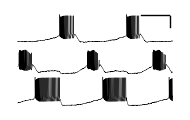

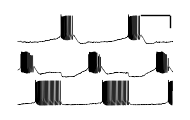

In [102]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    offsets=[46000, 79000]
    for ind in range(2):
        fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3))
        viz.vis_sample_plain(
            voltage_trace=out_targets[ind],
            t=time_vec,
            axV=ax,
            time_len=110000,
            offset=offsets[ind],
            col="k",
            scale_bar=True,
            scale_bar_voltage=True,
            print_label=False,
        )
        plt.savefig(f"../svg/panel_a_{ind}.svg")
        plt.show()

In [104]:
names = np.asarray([
    r"$E_s$"+"\nAB-LP", 
    r"$E_s$"+"\nAB-PY", 
    r"$E_s$"+"\nLP-AB", 
    r"$E_s$"+"\nLP-PY", 
    r"$E_s$"+"\nPY-LP", 
    r"$k_-$"+"\nAB-LP", 
    r"$k_-$"+"\nAB-PY", 
    r"$k_-$"+"\nLP-AB", 
    r"$k_-$"+"\nLP-PY", 
    r"$k_-$"+"\nPY-LP", 
    r"$E_s$"+"\nPD-LP", 
    r"$E_s$"+"\nPD-PY", 
    r"$k_-$"+"\nPD-LP", 
    r"$k_-$"+"\nPD-PY", 
    r"$V_{th}$"+"\nAB-LP", 
    r"$V_{th}$"+"\nPD-LP", 
    r"$V_{th}$"+"\nAB-PY", 
    r"$V_{th}$"+"\nPD-PY", 
    r"$V_{th}$"+"\nLP-AB", 
    r"$V_{th}$"+"\nLP-PY", 
    r"$V_{th}$"+"\nPY-LP", 
    r"$\Delta$"+"\nAB-LP", 
    r"$\Delta$"+"\nPD-LP", 
    r"$\Delta$"+"\nAB-PY", 
    r"$\Delta$"+"\nPD-PY", 
    r"$\Delta$"+"\nLP-AB", 
    r"$\Delta$"+"\nLP-PY", 
    r"$\Delta$"+"\nPY-LP", 
])

In [105]:
large_difference_inds = np.asarray([ 1,  6,  8,  9, 10, 14, 18, 23, 25])

es_condition = np.bitwise_or(large_difference_inds < 5.0, np.bitwise_and(large_difference_inds < 12., large_difference_inds > 9.))
es_differences = large_difference_inds[es_condition]

kminus_condition = np.bitwise_or(np.bitwise_and(large_difference_inds < 10., large_difference_inds > 4.), np.bitwise_and(large_difference_inds < 13., large_difference_inds > 11.))
kminus_differences = large_difference_inds[kminus_condition]

vth_condition = np.bitwise_and(large_difference_inds < 21., large_difference_inds > 13.)
vth_differences = large_difference_inds[vth_condition]

delta_condition = large_difference_inds > 20.
delta_differences = large_difference_inds[delta_condition]

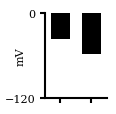

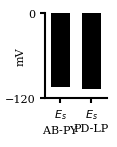

In [106]:
for counter, ind in enumerate([config1_ind, config2_ind]):
    with mpl.rc_context(fname="../../../.matplotlibrc"):
#         conductance_inds = [0, 5, 10, 15, 25]
        fig, ax = plt.subplots(1, 1, figsize=(0.8, 1.1))
        es_differences = es_differences[:2]
        ax.bar(np.arange(len(es_differences)), theta_synaptic_close[ind, es_differences], color="k", width=0.6)
        ax.set_xlim([-.5, 1.5])
        ax.set_xticks(np.arange(len(es_differences)))
        if counter == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([names[es_differences[0]]+r"$\;\;\;\;\;\;$", names[es_differences[1]]])
        ax.set_ylim([-120, 0])
        ax.set_yticks([-120, 0])
        ax.set_ylabel("mV", labelpad=-15)
        plt.savefig(f"../svg/panel_b1_{counter}.svg")
    plt.show()

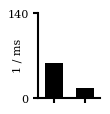

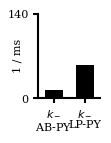

In [107]:
for counter, ind in enumerate([config1_ind, config2_ind]):
    with mpl.rc_context(fname="../../../.matplotlibrc"):
        conductance_inds = [0, 5, 10, 15, 25]
        fig, ax = plt.subplots(1, 1, figsize=(0.8, 1.1))
        kminus_differences = kminus_differences[:2]
        ax.bar(np.arange(len(kminus_differences)), theta_synaptic_close[ind, kminus_differences], color="k", width=0.6)
        ax.set_xlim([-.5, 1.5])
        ax.set_xticks(np.arange(len(kminus_differences)))
        if counter == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([names[kminus_differences[0]]+r"$\;\;\;\;\;\;$", names[kminus_differences[1]]])
        ax.set_ylim([0, 140])
        ax.set_yticks([0, 140])
        ax.set_ylabel("1 / ms", labelpad=-11)
        plt.savefig(f"../svg/panel_b2_{counter}.svg")
    plt.show()

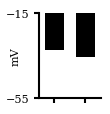

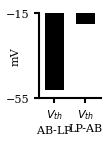

In [108]:
for counter, ind in enumerate([config1_ind, config2_ind]):
    with mpl.rc_context(fname="../../../.matplotlibrc"):
        conductance_inds = [0, 5, 10, 15, 25]
        fig, ax = plt.subplots(1, 1, figsize=(0.8, 1.1))
        vth_differences = vth_differences[:2]
        ax.bar(np.arange(len(vth_differences)), theta_synaptic_close[ind, vth_differences], color="k", width=0.6)
        ax.set_xlim([-.5, 1.5])
        ax.set_xticks(np.arange(len(vth_differences)))
        if counter == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([names[vth_differences[0]]+r"$\;\;\;\;\;\;$", names[vth_differences[1]]])
        ax.set_ylim([-55, -15])
        ax.set_yticks([-55, -15])
        ax.set_ylabel("mV", labelpad=-11)
        plt.savefig(f"../svg/panel_b3_{counter}.svg")
    plt.show()

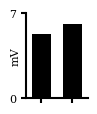

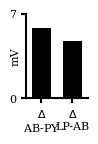

In [109]:
for counter, ind in enumerate([config1_ind, config2_ind]):
    with mpl.rc_context(fname="../../../.matplotlibrc"):
        conductance_inds = [0, 5, 10, 15, 25]
        fig, ax = plt.subplots(1, 1, figsize=(0.8, 1.1))
        delta_differences = delta_differences[:2]
        ax.bar(np.arange(len(delta_differences)), theta_synaptic_close[ind, delta_differences], color="k", width=0.6)
        ax.set_xlim([-.5, 1.5])
        ax.set_xticks(np.arange(len(delta_differences)))
        if counter == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels([names[delta_differences[0]]+r"$\;\;\;\;\;\;$", names[delta_differences[1]]])
        ax.set_ylim([0, 7])
        ax.set_yticks([0, 7])
        ax.set_ylabel("mV", labelpad=-8)
        plt.savefig(f"../svg/panel_b4_{counter}.svg")
    plt.show()

## Panel B: histograms over energy

In [110]:
hists = []
bin_edges = []
for config_ind in range(1):
    sims_out = pd.read_pickle(f"../../../results/energy_measure_comparison/simulation2_outputs_synapse_variation_config{config_ind}_50k.pkl")
    with open(f"../../../results/energy_measure_comparison/theta2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
        theta_synaptic = pickle.load(handle)
    with open(f"../../../results/energy_measure_comparison/seeds2_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
        seeds = pickle.load(handle)
    theta_conductance = theta.loc[config_ind]

    close = check_if_close_to_obs(sims_out.to_numpy(), sloppiness_durations=1.2, sloppiness_phases=2.0)

    print("Number of considered parameter sets: ", np.sum(close))
    sims_out_close = sims_out.loc[close]
    energies_close = np.sum(sims_out_close["energies"].to_numpy(), axis=1) / 10 / 1000
    hist, bin_edge = np.histogram(energies_close, range=(0, 30), bins=50, density=True)
    hists.append(hist)
    bin_edges.append(bin_edge)

Number of considered parameter sets:  76


In [111]:
min_ = np.min(sims_out_close["energies_per_spike"]["LP"])
max_ = np.max(sims_out_close["energies_per_spike"]["LP"])
(max_ - min_) / max_

0.3970179751166631

In [112]:
min_ = np.min(energies_close)
max_ = np.max(energies_close)
(max_ - min_) / max_

0.3221991260835201

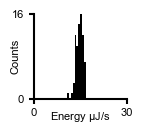

In [113]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.1))
    for config_ind in range(1):
#         ax.hist(bin_edges[config_ind][:-1], hists[config_ind], c="k")
        ax.hist(energies_close, range=(0, 30), bins=50, color="k")
    ax.set_xlabel(r"Energy $\mu J/s$", labelpad=-6)
    ax.set_ylabel("Counts", labelpad=-6)
    ax.set_xlim([0, 30])
    ax.set_ylim([0, 16])
    ax.set_yticks([0, 16])
    ax.set_xticks([0, 30])
    plt.savefig("../svg/panel_c.svg")
    plt.show()

## Panel C

In [114]:
all_potential_energy_savings = []
for config_ind in range(10):
    sims_out = pd.read_pickle(f"../../../results/energy_measure_comparison/simulation_outputs_synapse_variation_config{config_ind}_50k.pkl")
    with open(f"../../../results/energy_measure_comparison/theta_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
        theta_synaptic = pickle.load(handle)
    with open(f"../../../results/energy_measure_comparison/seeds_synapse_variation_config{config_ind}_50k.pkl", "rb") as handle:
        seeds = pickle.load(handle)
    theta_conductance = theta.loc[config_ind]

    close = check_if_close_to_obs(sims_out.to_numpy(), sloppiness_durations=1.2, sloppiness_phases=2.0)

    print("Number of considered parameter sets: ", np.sum(close))
    sims_out_close = sims_out.loc[close]
    energies_close = np.sum(sims_out_close["energies"].to_numpy(), axis=1) / 10 / 1000
    largest_energy = np.max(energies_close)
    smallest_energy = np.min(energies_close)
    
    potential_energy_savings = (largest_energy - smallest_energy) / largest_energy
    all_potential_energy_savings.append(potential_energy_savings)

Number of considered parameter sets:  44
Number of considered parameter sets:  6
Number of considered parameter sets:  25
Number of considered parameter sets:  5
Number of considered parameter sets:  13
Number of considered parameter sets:  21
Number of considered parameter sets:  52
Number of considered parameter sets:  39
Number of considered parameter sets:  20
Number of considered parameter sets:  37


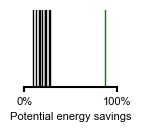

In [115]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1.0))
    for a in all_potential_energy_savings:
        ax.axvline(a, c="k", linewidth=1.0)
        
    ax.axvline(0.8730947552560072, c="g", linewidth=1.0)
    ax.set_xlabel("Potential energy savings")
    ax.set_xticks([0, 1])
    ax.set_yticks([])
    ax.spines["left"].set_visible(False)
    ax.set_xticklabels(["0%", "100%"])
    plt.savefig("../svg/panel_d.svg")
    plt.show()

# Assemble figure

In [116]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [117]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}


f = Figure("20.3cm", "6.5cm",
           
    Panel(
          SVG("../svg/panel_a_0.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("a", 0*factor_svg, 2.2*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG("../svg/panel_a_1.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(0*factor_svg, 21*factor_svg),
    
    Panel(
          SVG("../svg/panel_b1_0.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("b", 0*factor_svg, 2.3*factor_svg, **kwargs_text),
    ).move(36*factor_svg, 0.1*factor_svg),
           
    Panel(
          SVG("../svg/panel_b1_1.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(36*factor_svg, 21.1*factor_svg),
           
    Panel(
          SVG("../svg/panel_b2_0.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(55*factor_svg, 0*factor_svg),
           
    Panel(
          SVG("../svg/panel_b2_1.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(55*factor_svg, 21*factor_svg),
           
    Panel(
          SVG("../svg/panel_b3_0.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(73*factor_svg, 0*factor_svg),
           
    Panel(
          SVG("../svg/panel_b3_1.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(73*factor_svg, 21*factor_svg),
           
    Panel(
          SVG("../svg/panel_b4_0.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(92*factor_svg, 0*factor_svg),
           
    Panel(
          SVG("../svg/panel_b4_1.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
    ).move(92*factor_svg, 21*factor_svg),
           
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("c", -1*factor_svg, 2.2*factor_svg, **kwargs_text),
    ).move(115.2*factor_svg, 0.0*factor_svg),
           
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("d", -3.1*factor_svg, 1.0*factor_svg, **kwargs_text),
    ).move(117.3*factor_svg, 23.0*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig2_synaptic_variation.svg")
svg('../fig/fig2_synaptic_variation.svg')